Aufgaben die zu erledigen sind:
- Product Shelf bereinigen --> schlecht gekaufte Produkte
- Produkte empfehlen die noch nicht eingekauft wurden

3 mögliche Systeme:
- Simple Recommender --> Top Products
    - Decide on the metric or score to rate products on
    - Calcualte the score for every product
    - Sort the products based on the score and output the top results
    
- Content Based Recommender --> Uses item meta data
- Collaborative Recommender --> Products from other user that looks pretty similar


Problems:
Contrarian to rating data, purchase data has no upper band of the evaluated score
There is no explicit rating data, so it has to be generated from implicit information available

Ressources:
- https://medium.com/datadriveninvestor/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6
- https://www.datacamp.com/community/tutorials/recommender-systems-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=229765585186&utm_targetid=aud-299261629574:dsa-473406569915&utm_loc_interest_ms=&utm_loc_physical_ms=20143&gclid=Cj0KCQiA-bjyBRCcARIsAFboWg2VIh0dOVFJAckISmcG52iT4y1gr732tQkw-i9-Pj2VubR5WXq4IWcaArhsEALw_wcB


Performance:
This might be an issue.
A possible solution is: https://towardsdatascience.com/how-to-analyse-100s-of-gbs-of-data-on-your-laptop-with-python-f83363dda94


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # used for histogram


raw_data = pd.read_csv ("Recommender4Retail.csv", index_col=[0]) # low_memory option is depricated
raw_data.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
1,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,dairy eggs,soy lactosefree
3,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,snacks,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,snacks,popcorn jerky
5,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,household,paper goods


In [2]:
# Exploring the Data
'''
- What is eval_set, order_dow, reordered and can what can they be used for?
- Can the amount a product has been bought, seen as a implicit ratings? There might be some problems to it depending on the product...
- 
'''

raw_data.info()
raw_data.describe()

data = raw_data
data = raw_data.head(5000) # reduced for testing purposes, if this line is commented out, all querys use the full Dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 1 to 33819106
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              int64  
 8   add_to_cart_order       int64  
 9   reordered               int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  department              object 
 14  aisle                   object 
dtypes: float64(1), int64(10), object(4)
memory usage: 4.0+ GB


In [106]:
#Unique Values for specified colums
cols = ('eval_set','order_dow','add_to_cart_order')
for var in cols:
    res = data[var].unique()
    print('{2}: UniqueValues {0}, No. of unique values {1} '.format(res,len(res),var))


#Count occurence of each value
#print(data.eval_set.value_counts())

eval_set: UniqueValues ['prior' 'train'], No. of unique values 2 
order_dow: UniqueValues [2 3 4 1 5 0 6], No. of unique values 7 
add_to_cart_order: UniqueValues [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46], No. of unique values 46 


In [116]:
# filter a user
user1 = data[(data.user_id == 1)] # data[(data.user_id == 1) & (data.product_id == 196)]

# amount of products bought by user
# show the top 10 user with most products bought
n_by_user = data.groupby('user_id')['product_id'].count()
print(n_by_user.nlargest(10))

# number of times a product is bought
# show the products most bought
n_of_products = data.groupby('product_id')['user_id'].count()
print(n_of_products.nlargest(10))

#what is product 24852? Banana :-)
print(data[(data.product_id == 24852)]['product_name'].unique())

user_id
27    785
17    300
31    299
29    242
2     226
14    221
7     215
21    211
19    204
37    200
Name: product_id, dtype: int64
product_id
24852    45
7350     34
21903    34
27086    33
2966     31
18534    31
21137    30
44632    28
33754    27
47766    26
Name: user_id, dtype: int64
['Banana']


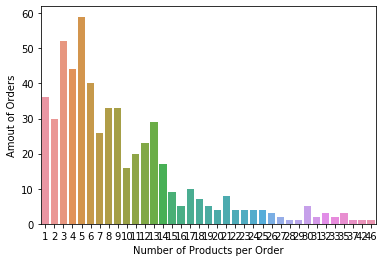

In [114]:
# Number of products bought per order
n_prod_order = data.groupby('order_id')['product_id'].count().value_counts().sort_index() # first row = number of products per order, second row = how many orders
# This does not consider if a product is bought multiple times in one order...

plt.figure()
sns.barplot(x=n_prod_order.index, y=n_prod_order.values)
plt.xlabel('Number of Products per Order')
plt.ylabel('Amout of Orders')
plt.show()


In [26]:
# looking at a specific user / product transaction

data[(data.user_id == 1) & (data.product_id == 196)]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
1,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages,soft drinks
6,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,beverages,soft drinks
12,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,beverages,soft drinks
17,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,beverages,soft drinks
22,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,beverages,soft drinks
30,3367565,1,prior,6,2,7,19.0,196,1,1,Soda,77,7,beverages,soft drinks
34,550135,1,prior,7,1,9,20.0,196,1,1,Soda,77,7,beverages,soft drinks
40,3108588,1,prior,8,1,14,14.0,196,2,1,Soda,77,7,beverages,soft drinks
48,2295261,1,prior,9,1,16,0.0,196,4,1,Soda,77,7,beverages,soft drinks
51,2550362,1,prior,10,4,8,30.0,196,1,1,Soda,77,7,beverages,soft drinks


# Recommender Building
This is done in several steps<p>
1. Preparing the data<p>
2. Running the Recommender<p>
3. Evaluating the results<p>

Explain the difference between content based, collaborative filtering and memory based methods here....

In [3]:
# create a matrix with user, product and occurence as value (= number of times purchased)

matrix = pd.crosstab(data.user_id, data.product_id) 
# if we want precentage add parameter normalize=True

# this could alternatively be done by groupby
matrix_g = data.groupby(['user_id', 'product_id'])['product_id'].count().unstack().fillna(0)


# or with pivot_table - already normalized the ratings
# sigmoid function
func = lambda x: x.count() / (1+x.count())
pivot_data = data[['user_id','product_id']]
matrix_p = pivot_data.pivot_table(index='user_id',columns='product_id',values='product_id',aggfunc=func,fill_value=0)

matrix_p.reset_index(inplace=True)
#matrix_p.index.name = None

matrix_p.head(1)
# the matrix has a lot of empty values (is very sparse), maybe with reducing the number of products this will be better?

product_id,user_id,23,34,79,93,95,100,116,169,196,...,49517,49519,49533,49573,49588,49615,49617,49662,49680,49683
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.916667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# converting the matrix back to a table for further processing
v_table = matrix.stack().reset_index()
v_table.columns = ['user_id','product_id','amount']

# remove rows with amount = 0
v_table = v_table[(v_table.amount != 0)]

print(v_table.head())

x = data.groupby(['user_id','product_id']).size()

print(x.head(20))

user_id  product_id  amount
8          1         196      11
358        1       10258      10
364        1       10326       1
457        1       12427      10
480        1       13032       4
user_id  product_id
1        196           11
         10258         10
         10326          1
         12427         10
         13032          4
         13176          2
         14084          1
         17122          1
         25133          9
         26088          3
         26405          3
         27845          1
         30450          1
         35951          1
         38928          2
         39657          2
         41787          1
         46149          4
         49235          3
2        23             1
dtype: int64


In [8]:

# Amount of times a product has been bought needs to be turned into a rating with range 0-1
# Not sure if sigmoid function or percentage is better, lets try both
v_table['rating_sig'] = v_table.amount / (1+v_table.amount)
v_table['rating_per'] = v_table.amount / v_table.amount.sum()
v_table.head()

# Renaming the column 'amount' to rating, since in the context of a recommender it's handeled as a rating
#v_table = v_table.rename(columns={'amount': 'rating'})


,user_id,product_id,amount,rating_sig,rating_per
8,1,196,11,0.916667,0.0022
358,1,10258,10,0.909091,0.0020
364,1,10326,1,0.500000,0.0002
457,1,12427,10,0.909091,0.0020
480,1,13032,4,0.800000,0.0008


In [9]:
#Creating a dataframe with the number of ratings and the average rating for each product

# Getting the average rating of all products (Maybe this 'amount' value has to be converted to a fixed scale before?)
ratings = pd.DataFrame(v_table.groupby('product_id')['rating_sig'].mean())

# Add the number of times a Product has been bought/rated to the df
ratings['number_of_ratings'] = v_table.groupby('product_id')['amount'].count()

ratings.head()

,rating_sig,number_of_ratings
product_id,,
23,0.500000,1
34,0.666667,1
79,0.500000,1
93,0.500000,1
95,0.500000,1


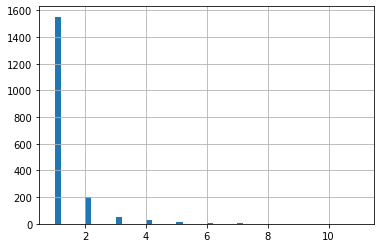

In [17]:
# Lets look at the distribution of the ratings

import matplotlib.pyplot as plt
%matplotlib inline
ratings['number_of_ratings'].hist(bins=50)

In [10]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating_sig,number_of_ratings
product_id,,
21137,0.643251,11
26209,0.525000,10
24852,0.762540,10
21903,0.754321,9
17794,0.620833,8
31717,0.500000,8
13176,0.655952,7
27086,0.692177,7
47766,0.689286,7


In [111]:
# Calculating the correlation between a product and the catalog

def recommend (product):
    r = matrix_p.corrwith(matrix_p[product])
    res = r.sort_values(ascending=False)[1:6]
    print(res) #the first product is always itself and therefore needs to be filtered
    
    prod = data[(data.product_id == product)].product_name.unique()
    prod_r = data[(data.product_id.isin(res.index.tolist()))].product_name.unique()
    print('For {0}, the recommended products are {1}'.format(prod,prod_r))
    
recommend(21137)


product_id
39275    0.685674
24852    0.637258
42265    0.545478
26209    0.541292
30391    0.499684
dtype: float64
For ['Organic Strawberries'], the recommended products are ['Banana' 'Organic Baby Carrots' 'Organic Blueberries' 'Organic Cucumber'
 'Limes']
